In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from causalgraphicalmodels import CausalGraphicalModel
import pickle

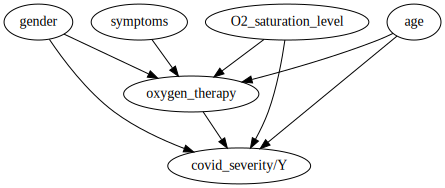

In [2]:
covid_dag_simple = CausalGraphicalModel(
    nodes=["covid_severity/Y", 
           "oxygen_therapy",
           "age",
           "O2_saturation_level","gender","symptoms",],
    edges=[
        ("O2_saturation_level","oxygen_therapy"),
        ("O2_saturation_level","covid_severity/Y"),
        ("oxygen_therapy", "covid_severity/Y"),
        ("symptoms","oxygen_therapy"),
        ("age","covid_severity/Y"),
        ("gender","covid_severity/Y"),
        ("gender","oxygen_therapy"),
        ("age","oxygen_therapy"),
    ]
)
covid_dag_simple.draw()

In [3]:
with open('covid_data.pickle','rb') as handle:
    covid_data = pickle.load(handle)
covid_data

,age_calculated,ncipr_min_osat,ncipr_how_severe_self,oxygen_administered,male,female,Bluish Lips/Face,Chest Pressure/Chest Pain,Chills or Shaking,Complete Loss of Smell (Anosmia),...,Other,Partial Loss of Smell (Partial Anosmia),Partial Loss of Taste (Partial Ageusia),Runny Nose/Sinus Congestion,Shortness of Breath/Difficulty Breathing,Skin rash or Skin ulcers,Sneezing,Sore Throat,Unusual Fatigue/Lethargy,Wheezing
1,47,93,2,1,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
2,65,94,4,0,0,1,0,1,1,1,...,0,0,0,1,1,0,1,1,1,1
3,43,92,4,0,0,1,0,1,1,1,...,0,0,0,0,1,0,0,1,1,0
4,63,93,4,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
5,59,93,4,0,0,1,0,1,1,0,...,1,1,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,41,95,1,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,1,1,0
2208,34,93,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2209,30,93,4,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,1,1
2210,43,93,4,0,0,1,0,1,1,0,...,0,1,1,1,0,0,1,1,1,0


In [4]:
path = '../NCIPR_Data_and_Measure_092721/Thomason_Scientific_Data_NCIPR_Paper2021/'

In [5]:
def dataCleaning(covid_data):
    # replace the nas with blanks
    covid_data.fillna('blank', inplace=True)
    
    # define the columns to keep using the dag
    columns_to_keep = ['ncipr_how_severe_self','ncipr_symptoms_all','age_calculated','ncipr_gender','ncipr_treat_med_therapy','ncipr_min_osat']
    covid_data.drop(covid_data.columns.difference(columns_to_keep), axis = 1, inplace=True)

    # add an oxygen administered column - binary
    covid_data['oxygen_administered'] = covid_data['ncipr_treat_med_therapy'].str.contains("Oxygen Therapy")
    covid_data['oxygen_administered'] = covid_data['oxygen_administered'].apply(lambda x: 0 if x==False 
                                                                                else 1)

#     covid_data['o2_administered'] = covid_data['oxygen_administered'].map(lambda z: 1 if z == 1 else 0)
#     covid_data['o2_NOT_administered'] = covid_data['oxygen_administered'].map(lambda z: 1 if z == 0 else 0)
    
    covid_data = covid_data.drop(axis=1, columns=['ncipr_treat_med_therapy'])
#     covid_data = covid_data.drop(axis=1, columns=['oxygen_administered'])
    
    # Convert age from float to int (rounding). Median replaces 0.
    covid_data['age_calculated'] = covid_data['age_calculated'].apply(lambda x: 0 if "blank" in x 
                                                                      else (89 if "+" in x 
                                                                            else int(np.round(float(x)))))
    
    x = list(covid_data['age_calculated'])
    non_zero_indices = [i for i, e in enumerate(x) if e != 0]
    non_zero_values = []
    for i in range(len(non_zero_indices)):
        non_zero_values.append(x[non_zero_indices[i]])
    median_age = int(np.round(np.median(non_zero_values)))
    
    covid_data['age_calculated'] = covid_data['age_calculated'].apply(lambda x: median_age if x==0 
                                                                      else x)
    
    # Convert gender to 2 digit binary.
    covid_data['male'] = covid_data['ncipr_gender'].apply(lambda x: 1 if 'Male' in x 
                                                                                else 0)  
    covid_data['female'] = covid_data['ncipr_gender'].apply(lambda x: 1 if 'Female' in x
                                                                                else 0)  
    
    covid_data = covid_data.drop(axis=1, columns=['ncipr_gender'])
    
    # Convert symptoms to list and one hot encode each symptom to have a separate column
    symptoms_df = covid_data['ncipr_symptoms_all'].str.get_dummies(sep=',')
    covid_data = pd.concat([covid_data, symptoms_df], axis=1)
    covid_data = covid_data.drop(axis=1, columns=['ncipr_symptoms_all'])

    # osat cleaning
    bad_data = ["don't know",'N/A','n/A','N\A','unknown','Not applicable','Not applicable, no SOB noted',
                   'no SOB noted','N\a','high eighties','N/all','NA','N.A','n/a','n/a ','Ñ/A', 'N\\a',
                   'Ñ/a','none','N?A','No','None','Na','N/a','NAm','0','2','NA ',"O", 'Na ', 'N/A ']
    
    for s in bad_data:
        covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace(s,'blank')
    
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('Low 80s or lower','80')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('80s','80')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("80's",'80')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('high eighties','87')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('96/49','96')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('95 at rest, 80 with activity','95')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('0.64','64')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('86%, but not sustained, it increases in time without intervention ',
                                                                        '86')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('85 or 86','85')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("70's..",'72')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("85 I think -- check your records",
                                                                        '85')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("<82",'81')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("88  ?",'88')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].str.replace('%','')
           
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].apply(lambda x: 0 if "blank" in x 
                                                                      else int(np.round(float(x))))
    
    covid_data = covid_data.drop(axis=1, columns=['blank'])
    
    x = list(covid_data['ncipr_min_osat'])
    non_zero_indices = [i for i, e in enumerate(x) if e != 0]
    non_zero_values = []
    for i in range(len(non_zero_indices)):
        non_zero_values.append(x[non_zero_indices[i]])
    median_osat = int(np.round(np.median(non_zero_values)))

    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].apply(lambda x: median_osat if x==0
                                                                  else x)

    covid_data['ncipr_how_severe_self'] = covid_data['ncipr_how_severe_self'].apply(lambda x: 0 if 'Very mild'  in x
                                                                                    else (1 if 'Mild to moderate' in x
                                                                                          else (2 if 'Life-threatening' in x 
                                                                                                else (3 if 'Severe to Extreme' in x 
                                                                                                      else (4 if 'Moderate to severe' in x else 'blank'))) )  )
    
    covid_data.drop(covid_data[covid_data['ncipr_how_severe_self'] == 'blank'].index, inplace = True)
    
    sense_cols = 'oxygen_administered'
    
    return covid_data, sense_cols

In [6]:
covid_data = pd.read_csv(path+'052321_NCIPR1_dataset.csv',skiprows=[1])
covid_data,sense_cols = dataCleaning(covid_data)
covid_data

,age_calculated,ncipr_min_osat,ncipr_how_severe_self,oxygen_administered,male,female,Bluish Lips/Face,Chest Pressure/Chest Pain,Chills or Shaking,Complete Loss of Smell (Anosmia),...,Other,Partial Loss of Smell (Partial Anosmia),Partial Loss of Taste (Partial Ageusia),Runny Nose/Sinus Congestion,Shortness of Breath/Difficulty Breathing,Skin rash or Skin ulcers,Sneezing,Sore Throat,Unusual Fatigue/Lethargy,Wheezing
1,47,93,2,1,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
2,65,94,4,0,0,1,0,1,1,1,...,0,0,0,1,1,0,1,1,1,1
3,43,92,4,0,0,1,0,1,1,1,...,0,0,0,0,1,0,0,1,1,0
4,63,93,4,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
5,59,93,4,0,0,1,0,1,1,0,...,1,1,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,41,95,1,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,1,1,0
2208,34,93,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2209,30,93,4,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,1,1
2210,43,93,4,0,0,1,0,1,1,0,...,0,1,1,1,0,0,1,1,1,0


In [ ]:
# with open('covid_data.pickle','wb') as handle:
#     pickle.dump(covid_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# ['Very mild',
#  'Mild to moderate',
#  'Life-threatening',
#  'Unsure',
#  'blank',
#  'Severe to Extreme',
#  'Moderate to severe']

In [ ]:
# scaler = StandardScaler()
# scaler.fit(covid_data)
# scaled = scaler.transform(covid_data)
# scaled_df = pd.DataFrame(scaled, columns=covid_data.columns)
# scaled_df